In [2]:
#import torch
import torch
from fontTools.merge import timer
from pandas.io.sas.sas_constants import dataset_length
from torch import nn
from torch.utils.data import Dataset, DataLoader

#import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

#import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from timeit import default_timer as timer 
from tqdm.auto import tqdm

import helper_function
from helper_function import pred_and_plot_image

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.4.0
0.19.0


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
train_data = datasets.FashionMNIST(
    root= 'data',
    train=True,
    transform=transforms.ToTensor(),
    download=False,
    target_transform=None)
test_data = datasets.FashionMNIST(
    root= 'data',
    train=False,
    transform=transforms.ToTensor(),
    download=False,
    target_transform=None)

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
#check the data type of train_data
image_0, label_0 = train_data[0]
image_0.shape

torch.Size([1, 28, 28])

In [8]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
class_name_idx = train_data.class_to_idx
class_name_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [10]:
target = train_data.targets
target

tensor([9, 0, 0,  ..., 3, 0, 5])

Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

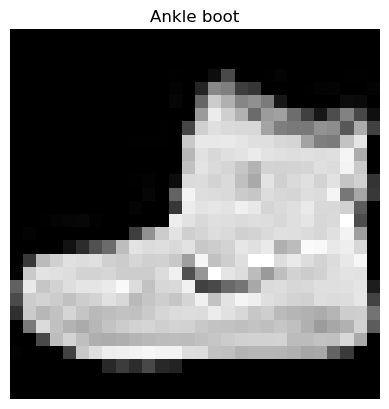

In [11]:
#visualizing data
print(f"Image shape: {image_0.shape}")
plt.imshow(image_0.squeeze(), cmap='gray')
plt.title(class_names[label_0])
plt.axis('off')

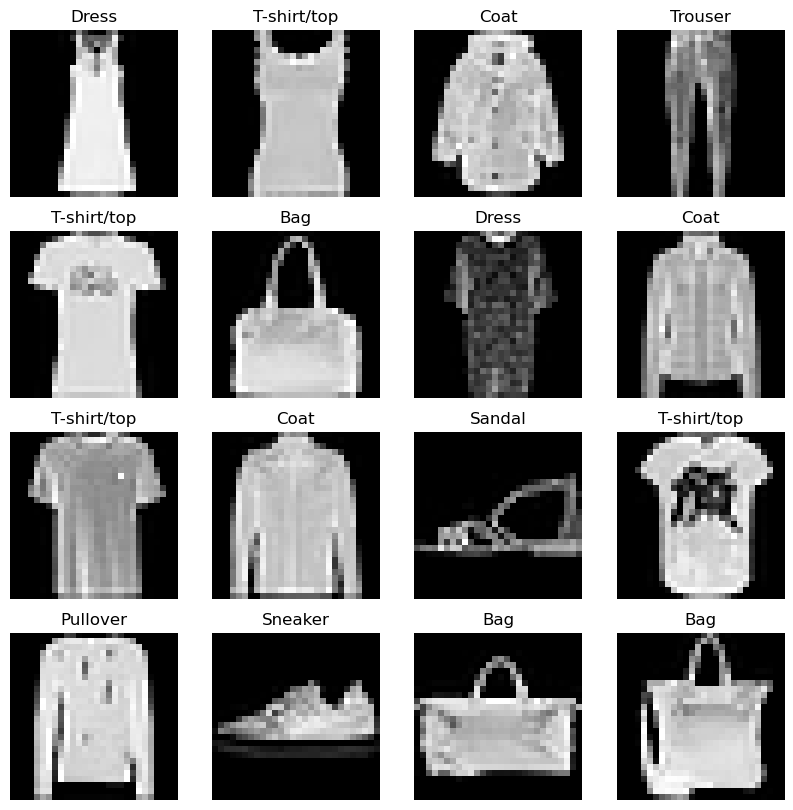

In [12]:
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')
    

In [19]:
img, label = train_data[1]
img.squeeze().shape

torch.Size([28, 28])

In [14]:
#split train_data, test_data into batch
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False)
train_features_batch, train_lables_batch = next(iter(train_dataloader))
train_features_batch.shape, train_lables_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [15]:
#Build a model with CNN
class FASHION_MNIST_Model_CNN(nn.Module):
    def __init__(self, in_channels: int, 
                 hidden_units: int,
                 out_channels: int,
                 ):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features= out_channels
                      )
        )
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [16]:
torch.manual_seed(42)
model_2 = FASHION_MNIST_Model_CNN(in_channels=1,
                                  hidden_units=10,
                                  out_channels=len(class_names)).to(device)

In [17]:
rand_image_tensor = torch.rand(( 1, 1, 28, 28))
model_2(rand_image_tensor.to(device))

KeyboardInterrupt: 

In [142]:
#Set up the loss funciton and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)


In [143]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss , train_acc = 0, 0
    model.train()
    for  X,y in data_loader:
        X, y = X.to(device), y.to(device)
    #for batch_idx, (X,y) in train_dataloader:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Train loss: {(train_loss / len(data_loader)):.5f} | Train acc: {(train_acc / len(data_loader)):.5f} % on {device}")

In [144]:
def test_step(model: nn.Module,
              data_loader: DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss , test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        print(f"Test loss: {(test_loss / len(data_loader)):.5f} | Test acc: {(test_acc / len(data_loader)):.5f} % on {device}")  

In [153]:
def eval_model(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device = device):
    eval_loss, eval_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)
            eval_pred = model(X)
            loss = loss_fn(eval_pred, y)
            eval_loss += loss.item()
            eval_acc += accuracy_fn(y, eval_pred.argmax(dim=1))
    return {"model_name": model.__class__.__name__,
            "model_loss": (eval_loss / len(data_loader)),
            "model_acc": (eval_acc / len(data_loader)) }

In [145]:
#Training and testing the model_2 using training and test
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS  = 30
train_time_start = timer()
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=helper_function.accuracy_fn,
               device = device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              accuracy_fn=helper_function.accuracy_fn,
              loss_fn=loss_fn,
              device = device)
train_time_end = timer()
print(f"Train time on {device}: {train_time_end - train_time_start} seconds")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
Train loss: 0.59491 | Train acc: 78.30833 % on cuda
Test loss: 0.37614 | Test acc: 86.56150 % on cuda
Epoch 2/30
Train loss: 0.35876 | Train acc: 87.02667 % on cuda
Test loss: 0.34819 | Test acc: 87.61981 % on cuda
Epoch 3/30
Train loss: 0.32144 | Train acc: 88.37333 % on cuda
Test loss: 0.34524 | Test acc: 87.50998 % on cuda
Epoch 4/30
Train loss: 0.30142 | Train acc: 89.01167 % on cuda
Test loss: 0.31478 | Test acc: 88.73802 % on cuda
Epoch 5/30
Train loss: 0.28532 | Train acc: 89.60333 % on cuda
Test loss: 0.30989 | Test acc: 88.87780 % on cuda
Epoch 6/30
Train loss: 0.27464 | Train acc: 90.02167 % on cuda
Test loss: 0.30288 | Test acc: 89.49681 % on cuda
Epoch 7/30
Train loss: 0.26664 | Train acc: 90.40500 % on cuda
Test loss: 0.28418 | Test acc: 89.70647 % on cuda
Epoch 8/30
Train loss: 0.25967 | Train acc: 90.58167 % on cuda
Test loss: 0.29350 | Test acc: 89.52676 % on cuda
Epoch 9/30
Train loss: 0.25236 | Train acc: 90.68333 % on cuda
Test loss: 0.30783 | Test acc: 89

In [154]:
model_2_result = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            accuracy_fn=helper_function.accuracy_fn,
                            loss_fn=loss_fn,
                            device = device)

In [155]:
# Set up the predition function
def make_prediction(model: nn.Module,
                    data: list,
                    device: torch.device = device):
    pre_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            pre_logit = model(sample)
            
            pre_probs = torch.softmax(pre_logit.squeeze(), dim=0)
            
            pre_probs.append(pre_probs.cpu())
    
    return torch.stack(pre_probs)
            
            
            
            
            
            
            
            
            
            
            
        

{'model_name': 'FASHION_MNIST_Model_CNN',
 'model_loss': 0.2745021011430425,
 'model_acc': 89.91613418530352}